# Pseudo-first order comparison
In this notebook we'll compare the results of an analytically exact solution for a competetive pseudo-first order reaction with the simulation results obtained by tellurium

In [3]:
import tellurium as te
import numpy as np
import pandas as pd
import sbml_sim_helper

In [4]:
def get_pseudo_first_order_concentrations_implicit(t, initial_concentration_tuple, rate_constants_dict, kh=1e-05,):
    initial_concentration = initial_concentration_tuple[1]
    rate_constants_dict[initial_concentration_tuple[0] + '_bihydrolyzed'] = kh
    rate_const_sum = sum(list(rate_constants_dict.values()))
    conc_products_dict = {}
    conc_products_dict['time'] = t 
    conc_products_dict[initial_concentration_tuple[0]] = initial_concentration * np.exp(-t*rate_const_sum)
    for const_name, const_val in rate_constants_dict.items():
        conc_products_dict[const_name] = const_val/rate_const_sum * initial_concentration * (1-np.exp(-t*rate_const_sum))
    return conc_products_dict

In [5]:
def get_pseudo_first_order_concentrations_explicit(t, initial_concentration_tuple, rate_constants_dict, kh=1e-05, kon=0.001, koff=0.1,):
    rate_constants_dict_eff = {}
    rate_constants_dict_eff[initial_concentration_tuple[0] + '_bihydrolyzed'] = kh
    for k,v in rate_constants_dict.items():
        rate_constants_dict_eff[k] = (v*kon/(v+koff))
    initial_concentration = initial_concentration_tuple[1]
    rate_const_sum = sum(list(rate_constants_dict_eff.values()))
    conc_products_dict = {}
    conc_products_dict['time'] = t 
    conc_products_dict[initial_concentration_tuple[0]] = initial_concentration * np.exp(-t*rate_const_sum)
    for const_name, const_val in rate_constants_dict_eff.items():
        conc_products_dict[const_name] = const_val/rate_const_sum * initial_concentration * (1-np.exp(-t*rate_const_sum))
    return conc_products_dict

In [47]:
def get_pseudo_first_order_constants_implicit(t, main_concentration_tuple, concentration_dict):
    initial_concentration = main_concentration_tuple[0]
    final_concentration = main_concentration_tuple[1]
    #print(initial_concentration, final_concentration)
    rate_constants_dict = {}
    sum_species_final = np.round(sum(list(concentration_dict.values())), 7)
    #rate_const_sum = np.log(initial_concentration/final_concentration)/t
    rate_const_sum = np.log(initial_concentration/(initial_concentration-sum_species_final))/t
    for species,conc in concentration_dict.items():
        #rate_constants_dict[species] = (rate_const_sum*conc)/(initial_concentration - initial_concentration * np.exp(-t*rate_const_sum))
        rate_constants_dict[species] = rate_const_sum*conc/sum_species_final
    return rate_constants_dict

In [7]:
def get_pseudo_first_order_constants_explicit(t, initial_concentration, concentration_dict):
    rate_constants_dict = {}
    sum_species_final = sum(list(concentration_dict.values()))
    rate_const_sum = np.log(initial_concentration/(initial_concentration-sum_species_final))/t
    for species,conc in concentration_dict.items():
        rate_constants_dict[species] = (rate_const_sum*conc)/(initial_concentration - initial_concentration * np.exp(-t*rate_const_sum))
    return rate_constants_dict

In [8]:
def get_antimony_5ly_explicit(react_list, kh=1e-05, kon=0.001, koff=0.1, c_monolinker=5):
    return f'''
        CrosslinkerMonoHydrolized -> CrosslinkerBiHydrolized; kh*CrosslinkerMonoHydrolized;
        LYS_1 + CrosslinkerMonoHydrolized -> MonoHydro_1; (klys_1*kon/(klys_1 + koff))*CrosslinkerMonoHydrolized*LYS_1;
        LYS_2 + CrosslinkerMonoHydrolized -> MonoHydro_2; (klys_2*kon/(klys_2 + koff))*CrosslinkerMonoHydrolized*LYS_2;
        LYS_3 + CrosslinkerMonoHydrolized -> MonoHydro_3; (klys_3*kon/(klys_3 + koff))*CrosslinkerMonoHydrolized*LYS_3;
        LYS_4 + CrosslinkerMonoHydrolized -> MonoHydro_4; (klys_4*kon/(klys_4 + koff))*CrosslinkerMonoHydrolized*LYS_4;
        LYS_5 + CrosslinkerMonoHydrolized -> MonoHydro_5; (klys_5*kon/(klys_5 + koff))*CrosslinkerMonoHydrolized*LYS_5;

        LYS_1=1; LYS_2=1; LYS_3=1; LYS_4=1; LYS_5=1;
        CrosslinkerMonoHydrolized={c_monolinker};
        klys_1 = {react_list[0]};
        klys_2 = {react_list[1]};
        klys_3 = {react_list[2]};
        klys_4 = {react_list[3]};
        klys_5 = {react_list[4]};
        kh = {kh};
        kon = {kon}
        koff = {koff}
    '''

In [100]:
def get_antimony_5ly_implicit(react_list, kh=1e-05, c_monolinker=5):
    return f'''
        CrosslinkerMonoHydrolized -> CrosslinkerBiHydrolized; kh*CrosslinkerMonoHydrolized;
        LYS_1 + CrosslinkerMonoHydrolized -> MonoHydro_1; klys_1*CrosslinkerMonoHydrolized*LYS_1;
        LYS_2 + CrosslinkerMonoHydrolized -> MonoHydro_2; klys_2*CrosslinkerMonoHydrolized*LYS_2;
        LYS_3 + CrosslinkerMonoHydrolized -> MonoHydro_3; klys_3*CrosslinkerMonoHydrolized*LYS_3;
        LYS_4 + CrosslinkerMonoHydrolized -> MonoHydro_4; klys_4*CrosslinkerMonoHydrolized*LYS_4;
        LYS_5 + CrosslinkerMonoHydrolized -> MonoHydro_5; klys_5*CrosslinkerMonoHydrolized*LYS_5;

        LYS_1=1; LYS_2=1; LYS_3=1; LYS_4=1; LYS_5=1;
        CrosslinkerMonoHydrolized={c_monolinker};
        klys_1 = {react_list[0]};
        klys_2 = {react_list[1]};
        klys_3 = {react_list[2]};
        klys_4 = {react_list[3]};
        klys_5 = {react_list[4]};
        kh = {kh};
    '''

In [10]:
def get_antimony_2ly(react_list, kh=1e-05, kon=0.001, koff=0.1, c_monolinker=5):
    return f'''
        CrosslinkerMonoHydrolized -> CrosslinkerBiHydrolized; kh*CrosslinkerMonoHydrolized;
        LYS_1 + CrosslinkerMonoHydrolized -> MonoHydro_1; (klys_1*kon/(klys_1 + koff))*CrosslinkerMonoHydrolized*LYS_1;
        LYS_2 + CrosslinkerMonoHydrolized -> MonoHydro_2; (klys_2*kon/(klys_2 + koff))*CrosslinkerMonoHydrolized*LYS_2;

        LYS_1=1; LYS_2=1;
        CrosslinkerMonoHydrolized={c_monolinker};
        klys_1 = {react_list[0]};
        klys_2 = {react_list[1]};
        kh = {kh};
        kon = {kon}
        koff = {koff}
    '''

In [11]:
time=1000
c_ml = 0.5
kh = 1e-03
kon = 0.01
koff = 0.1
initial_concentration_tuple=('monolinker', c_ml)

In [12]:
rd2 = {'M1': 0.01, 'M2': 0.08}
l2 = list(rd2.values())

In [13]:
res_points2 = get_pseudo_first_order_concentrations_explicit(np.arange(time+1), initial_concentration_tuple=initial_concentration_tuple, rate_constants_dict=rd2, kh=kh, kon=kon, koff=koff)
df_res2 = pd.DataFrame(res_points2)

<AxesSubplot:xlabel='time'>

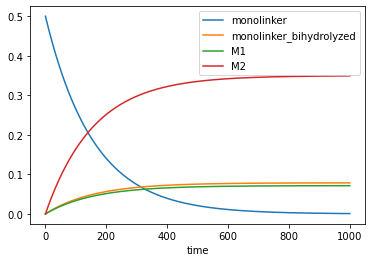

In [14]:
df_res2.plot(x='time')

In [15]:
rr_2lys = te.loada(get_antimony_2ly(l2, c_monolinker=c_ml, kh=kh, kon=kon, koff=koff))
results_2lys = rr_2lys.simulate(0, time)
df_res_2lys = pd.DataFrame(results_2lys, columns=results_2lys.colnames)

In [16]:
klys_2lys = sbml_sim_helper.get_rr_const_dict(rr_2lys, 'klys')

In [17]:
klys_2lys

{'klys_1': 0.01, 'klys_2': 0.08}

<AxesSubplot:xlabel='time'>

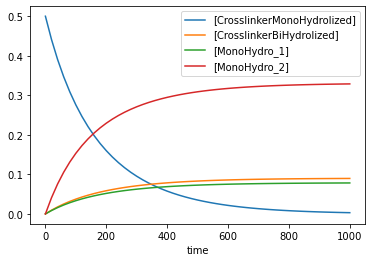

In [18]:
df_res_2lys[[col for col in df_res_2lys.columns if 'LYS' not in col]].plot('time')

In [19]:
df_res2.tail(1)

,time,monolinker,monolinker_bihydrolyzed,M1,M2
1000,1000,0.00087,0.078559,0.071418,0.349153


In [20]:
df_res_2lys.tail(1)

,time,[CrosslinkerMonoHydrolized],[CrosslinkerBiHydrolized],[LYS_1],[MonoHydro_1],[LYS_2],[MonoHydro_2]
50,1000.0,0.003109,0.08972,0.921674,0.078326,0.671155,0.328845


In [21]:
rd5 = {'M1': 0.01, 'M2': 0.03, 'M3': 0.05, 'M4': 0.1, 'M5': 0.005}
l5 = list(rd5.values())

In [22]:
res_points5 = get_pseudo_first_order_concentrations_explicit(np.arange(time/2 + 1), initial_concentration_tuple=('monolinker', c_ml), rate_constants_dict=rd5, kh=kh, kon=kon, koff=koff)
df_res5 = pd.DataFrame(res_points5)

<AxesSubplot:xlabel='time'>

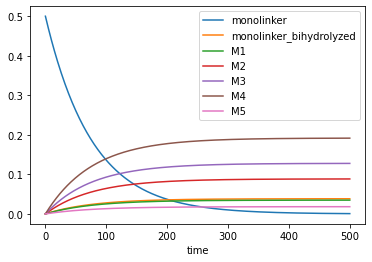

In [23]:
df_res5.plot(x='time')

In [24]:
rr_5lys = te.loada(get_antimony_5ly_explicit(l5, c_monolinker=c_ml, kh=kh, kon=kon, koff=koff))
results_5lys = rr_5lys.simulate(0, time/2)
df_res_5lys = pd.DataFrame(results_5lys, columns=results_5lys.colnames)

<AxesSubplot:xlabel='time'>

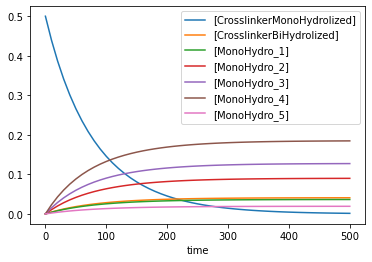

In [25]:
df_res_5lys[[col for col in df_res_5lys.columns if 'LYS' not in col]].plot('time')

In [26]:
df_res5.tail(1)

,time,monolinker,monolinker_bihydrolyzed,M1,M2,M3,M4,M5
500,500.0,0.000742,0.038327,0.034843,0.088447,0.127756,0.191635,0.018251


In [27]:
df_res_5lys.tail(1)

,time,[CrosslinkerMonoHydrolized],[CrosslinkerBiHydrolized],[LYS_1],[MonoHydro_1],[LYS_2],[MonoHydro_2],[LYS_3],[MonoHydro_3],[LYS_4],[MonoHydro_4],[LYS_5],[MonoHydro_5]
50,500.0,0.001452,0.040848,0.963547,0.036453,0.910043,0.089957,0.872704,0.127296,0.815269,0.184731,0.980737,0.019263


In [28]:
c_ml = 1
kh = 1e-03
time = 500
initial_concentration_tuple=('monolinker', c_ml)

In [29]:
res_points_s = get_pseudo_first_order_concentrations_implicit(np.arange(time+1), initial_concentration_tuple=('monolinker', c_ml), rate_constants_dict=rd5, kh=kh)
df_s = pd.DataFrame(res_points_s)
o = df_s.tail(1).to_dict(orient='records')[0]
m = {k:v for k,v in o.items() if 'M' in k} #or 'bihydro' in k
t_eq = (c_ml, o['monolinker'])

In [30]:
o

{'time': 500,
 'monolinker': 2.7487850079102147e-43,
 'M1': 0.05102040816326531,
 'M2': 0.1530612244897959,
 'M3': 0.25510204081632654,
 'M4': 0.5102040816326531,
 'M5': 0.025510204081632654,
 'monolinker_bihydrolyzed': 0.00510204081632653}

In [31]:
rr_5lys = te.loada(get_antimony_5ly_implicit(l5, c_monolinker=c_ml, kh=kh))
results_5lys = rr_5lys.simulate(0, time)
df_res_5lys = pd.DataFrame(results_5lys, columns=results_5lys.colnames)
i = df_res_5lys.tail(1).to_dict(orient='records')[0]
n = {k:v for k,v in i.items() if 'MonoHydro_' in k} # or 'BiHydro' in k
t_sim = (c_ml, i['[CrosslinkerMonoHydrolized]'])

In [32]:
i

{'time': 500.0,
 '[CrosslinkerMonoHydrolized]': 2.2676516829174582e-13,
 '[CrosslinkerBiHydrolized]': 0.006236985656475836,
 '[LYS_1]': 0.9395353499906384,
 '[MonoHydro_1]': 0.060464650009361645,
 '[LYS_2]': 0.829353033601546,
 '[MonoHydro_2]': 0.1706469663984547,
 '[LYS_3]': 0.7320923084675071,
 '[MonoHydro_3]': 0.2679076915324914,
 '[LYS_4]': 0.5359599821107254,
 '[MonoHydro_4]': 0.46404001788927346,
 '[LYS_5]': 0.9692963114863068,
 '[MonoHydro_5]': 0.03070368851369303}

In [33]:
kh

0.001

In [49]:
get_pseudo_first_order_constants_implicit(time, t_sim, n)

{'[MonoHydro_1]': 0.0006178424954955968,
 '[MonoHydro_2]': 0.0017437121946798748,
 '[MonoHydro_3]': 0.0027375459325948487,
 '[MonoHydro_4]': 0.00474167373197629,
 '[MonoHydro_5]': 0.0003137377546927418}

In [50]:
get_pseudo_first_order_constants_implicit(time, t_eq, m)

{'M1': 0.0005413458915614513,
 'M2': 0.0016240376746843538,
 'M3': 0.0027067294578072567,
 'M4': 0.005413458915614513,
 'M5': 0.00027067294578072567}

In [37]:
l5

[0.01, 0.03, 0.05, 0.1, 0.005]

In [223]:
rr_5lys = te.loada(get_antimony_5ly_implicit(l5, c_monolinker=c_ml, kh=kh))
rr_5lys.resetToOrigin()
df5 = sbml_sim_helper.sim_for_fake_t(rr_5lys, time)
#df5 = df5.drop(labels=['[CrosslinkerMonoHydrolized]', '[CrosslinkerBiHydrolized]'], axis=1)
df5

,time,[CrosslinkerMonoHydrolized],[CrosslinkerBiHydrolized],[LYS_1],[MonoHydro_1],[LYS_2],[MonoHydro_2],[LYS_3],[MonoHydro_3],[LYS_4],[MonoHydro_4],[LYS_5],[MonoHydro_5]
0,0.0,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.00000,1.000000,0.000000
1,250.0,-4.703420e-15,0.006237,0.939535,0.060465,0.829353,0.170647,0.732092,0.267908,0.53596,0.46404,0.969296,0.030704
2,500.0,-4.703420e-15,0.006237,0.939535,0.060465,0.829353,0.170647,0.732092,0.267908,0.53596,0.46404,0.969296,0.030704


In [286]:
rr_5lys = te.loada(get_antimony_5ly_implicit(l5, c_monolinker=c_ml, kh=kh))
r5 = rr_5lys.simulate(0, 20, 5)
df5 = pd.DataFrame(r5, columns=r5.colnames)
df5

,time,[CrosslinkerMonoHydrolized],[CrosslinkerBiHydrolized],[LYS_1],[MonoHydro_1],[LYS_2],[MonoHydro_2],[LYS_3],[MonoHydro_3],[LYS_4],[MonoHydro_4],[LYS_5],[MonoHydro_5]
0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,5.0,0.421251,0.003295,0.967589,0.032411,0.905884,0.094116,0.848114,0.151886,0.719297,0.280703,0.983661,0.016339
2,10.0,0.200020,0.004771,0.953408,0.046592,0.866635,0.133365,0.787759,0.212241,0.620564,0.379436,0.976426,0.023574
3,15.0,0.099678,0.005490,0.946582,0.053418,0.848155,0.151845,0.759962,0.240038,0.577544,0.422456,0.972925,0.027075
4,20.0,0.050797,0.005852,0.943161,0.056839,0.838991,0.161009,0.746327,0.253673,0.557005,0.442995,0.971165,0.028835


In [287]:
df5.iloc[1:] = df5.iloc[1:].apply(lambda x: x+np.random.normal(0, x[1]*10e-2) if x.name != 'time' and 'Crosslinker' not in x.name else x)
df5

,time,[CrosslinkerMonoHydrolized],[CrosslinkerBiHydrolized],[LYS_1],[MonoHydro_1],[LYS_2],[MonoHydro_2],[LYS_3],[MonoHydro_3],[LYS_4],[MonoHydro_4],[LYS_5],[MonoHydro_5]
0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,5.0,0.421251,0.003295,0.877135,0.031710,0.987700,0.092269,0.803022,0.157689,0.760935,0.316880,0.852826,0.016438
2,10.0,0.200020,0.004771,0.862954,0.045891,0.948451,0.131519,0.742666,0.218045,0.662202,0.415613,0.845591,0.023673
3,15.0,0.099678,0.005490,0.856128,0.052717,0.929971,0.149998,0.714870,0.245841,0.619181,0.458634,0.842089,0.027174
4,20.0,0.050797,0.005852,0.852707,0.056138,0.920808,0.159162,0.701234,0.259477,0.598643,0.479172,0.840329,0.028934


In [288]:
df5.to_csv('tmp_eq5.csv', index=False)

In [289]:
stochastic_simulation_model = te.StochasticSimulationModel(model=rr_5lys.getAntimony(),#,"../output/model_c3_antimony_asa_mono_only.txt",
                seed=1234, # not used
                variable_step_size = False,
                from_time=0,
                to_time=20,
                step_points=5)
stochastic_simulation_model.integrator = "gillespie"

In [290]:
vars_klys = sbml_sim_helper.get_rr_const_dict(rr_5lys, 'klys')

In [291]:
bounds = {v: (1e-5,1e0) for v in vars_klys.keys()}

In [292]:
parameter_est = sbml_sim_helper.ParameterEstimation(stochastic_simulation_model,bounds)
parameter_est.setDataFromFile('tmp_eq5.csv', headers=True)
res_fit = parameter_est.run(params={'strategy': 'currenttobest1bin', 'disp': False, 'maxiter': 5000})

In [293]:
res_fit

array([0.01766881, 0.01818344, 0.0551515 , 0.09791217, 0.01696398])

In [46]:
vars_klys

{'klys_1': 0.01,
 'klys_2': 0.03,
 'klys_3': 0.05,
 'klys_4': 0.1,
 'klys_5': 0.005}